In [23]:
# ============================================================
# Core Python
# ============================================================
import os
import numpy as np
from PIL import Image

# ============================================================
# Torch
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# Albumentations
# ============================================================
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ============================================================
# TIFF Reader
# ============================================================
import rasterio

# ============================================================
# Visualization
# ============================================================
import matplotlib.pyplot as plt

# ============================================================
# Progress bar
# ============================================================
from tqdm import tqdm

# ============================================================
# Image quality metrics
# ============================================================
from skimage.metrics import peak_signal_noise_ratio as psnr_fn
from skimage.metrics import structural_similarity as ssim_fn


Device: cuda


In [24]:
def load_tif(path, scale_reflectance=True):
    """
    Load a multi-band TIFF using rasterio -> returns H x W x C (float32).
    If scale_reflectance=True, divides by 10000 (typical Sentinel-2 scaling).
    """
    with rasterio.open(path) as src:
        arr = src.read()         # (C, H, W)
        arr = np.transpose(arr, (1, 2, 0))  # (H, W, C)

    arr = arr.astype(np.float32)
    if scale_reflectance:
        # Avoid dividing by zero; scale to [0, 1] approx
        arr = arr / 10000.0
    return arr


In [25]:
class ROIDataset(Dataset):
    """
    Loads ONLY the specified ROI folder (e.g., ROIs1868_73) 
    and all patch folders inside it.
    """
    def __init__(self, root_dir, roi_name="ROIs1868_73", transform=None):
        self.root_dir = root_dir
        self.roi_name = roi_name
        self.transform = transform
        self.samples = []

        # go to only this ROI
        roi_path = os.path.join(root_dir, roi_name)

        if not os.path.isdir(roi_path):
            raise ValueError(f"ROI folder not found: {roi_path}")

        # scan patch folders inside the selected ROI
        for patch_folder in sorted(os.listdir(roi_path)):
            patch_path = os.path.join(roi_path, patch_folder)
            if not os.path.isdir(patch_path):
                continue

            agg, tgt = None, None

            for fname in os.listdir(patch_path):
                fname_up = fname.upper()
                if "FMASK_COMPOSITE" in fname_up:
                    agg = os.path.join(patch_path, fname)
                if "CLEAN_TARGET" in fname_up:
                    tgt = os.path.join(patch_path, fname)

            if agg and tgt:
                self.samples.append({"agg": agg, "tgt": tgt})

        print(f"Loaded ROI: {roi_name}")
        print("Total samples found:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        X = load_tif(s["agg"])
        Y = load_tif(s["tgt"])

        # keep first 13 channels
        if X.shape[2] > 13: X = X[..., :13]
        if Y.shape[2] > 13: Y = Y[..., :13]

        # resize target if size mismatch
        if X.shape[:2] != Y.shape[:2]:
            bands = []
            for b in range(Y.shape[2]):
                band = (Y[..., b] * 10000).astype(np.uint16)
                band_pil = Image.fromarray(band)
                band_resized = np.array(
                    band_pil.resize((X.shape[1], X.shape[0]), resample=Image.BILINEAR)
                ).astype(np.float32) / 10000.0
                bands.append(band_resized)
            Y = np.stack(bands, axis=-1)

        # Albumentations transforms
        aug = self.transform(image=X, mask=Y)
        X_t = aug["image"]
        Y_t = aug["mask"]

        # Ensure CHW for mask
        if Y_t.ndim == 3 and Y_t.shape[0] != 13:
            Y_t = Y_t.permute(2, 0, 1)

        return X_t.float(), Y_t.float()


In [26]:
# 13-band normalization: since load_tif scales to [0,1] (approx),
# use mean=0, std=1 (no extra scaling). Albumentations Normalize expects values in 0..1.
norm_mean = [0.0] * 13
norm_std  = [1.0] * 13

train_transform = A.Compose([
    A.RandomCrop(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # no additional Normalize scaling required because load_tif scaled by 1/10000
    A.Normalize(mean=norm_mean, std=norm_std, max_pixel_value=1.0),
    ToTensorV2()
])

val_transform = A.Compose([
    A.CenterCrop(256, 256),
    A.Normalize(mean=norm_mean, std=norm_std, max_pixel_value=1.0),
    ToTensorV2()
])

root_path = r"D:\Timegate Images"

train_ds = ROIDataset(root_path, roi_name="ROIs1868_73", transform=train_transform)
val_ds   = ROIDataset(root_path, roi_name="ROIs1868_73", transform=val_transform)

print("train samples =", len(train_ds))
print("val samples   =", len(val_ds))

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)


Loaded ROI: ROIs1868_73
Total samples found: 240
Loaded ROI: ROIs1868_73
Total samples found: 240
train samples = 240
val samples   = 240


In [27]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=13, out_channels=13):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.conv1 = DoubleConv(128, 64)
        self.out = nn.Conv2d(64, out_channels, 1)
    def forward(self, x):
        c1 = self.down1(x); p1 = self.pool(c1)
        c2 = self.down2(p1); p2 = self.pool(c2)
        c3 = self.down3(p2); p3 = self.pool(c3)
        c4 = self.down4(p3); p4 = self.pool(c4)
        bn = self.bottleneck(p4)
        u4 = torch.cat([self.up4(bn), c4], dim=1); u4 = self.conv4(u4)
        u3 = torch.cat([self.up3(u4), c3], dim=1); u3 = self.conv3(u3)
        u2 = torch.cat([self.up2(u3), c2], dim=1); u2 = self.conv2(u2)
        u1 = torch.cat([self.up1(u2), c1], dim=1); u1 = self.conv1(u1)
        return self.out(u1)

model = UNet(in_channels=13, out_channels=13).to(device)
print(model)


UNet(
  (down1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down3): DoubleConv(
    (net): Sequential(
      (0): Conv2d(128, 256, kernel_size

In [28]:
def loss_fn(pred, target):
    return F.l1_loss(pred, target) + 0.1 * F.mse_loss(pred, target)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_epoch():
    model.train()
    total = 0.0
    count = 0
    for X, Y in tqdm(train_loader):
        X = X.to(device).float()
        Y = Y.to(device).float()
        pred = model(X)
        loss = loss_fn(pred, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()
        count += 1
    return total / (count if count > 0 else 1.0)

def validate_epoch():
    """
    Returns PSNR and per-band averaged SSIM for 13-channel Sentinel-2 images.
    """
    model.eval()
    psnrs, ssims = [], []

    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(device).float()
            Y = Y.to(device).float()

            # forward pass
            pred = model(X)

            # convert CHW -> HWC for numpy ops
            pred_np = pred.cpu().numpy()[0].transpose(1,2,0)
            Y_np    = Y.cpu().numpy()[0].transpose(1,2,0)

            # clip range for PSNR/SSIM
            pred_np_clipped = np.clip(pred_np, 0.0, 1.0)
            Y_np_clipped    = np.clip(Y_np,   0.0, 1.0)

            # -------- PSNR --------
            try:
                psnrs.append(psnr_fn(Y_np_clipped, pred_np_clipped, data_range=1.0))
            except:
                pass

            # -------- SSIM per-band average --------
            ssim_vals = []
            for b in range(pred_np_clipped.shape[2]):  # 13 bands
                try:
                    ssim_vals.append(
                        ssim_fn(
                            Y_np_clipped[:,:,b],
                            pred_np_clipped[:,:,b],
                            data_range=1.0
                        )
                    )
                except:
                    pass

            if len(ssim_vals) > 0:
                ssims.append(np.mean(ssim_vals))

    # final outputs
    return (
        np.mean(psnrs) if psnrs else 0.0,
        np.mean(ssims) if ssims else 0.0
    )



In [29]:
epochs = 20
best_psnr = -1

train_losses = []
val_psnrs = []
val_ssims = []

for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")

    # training
    tloss = train_epoch()

    # validation (returns PSNR, SSIM)
    p, s = validate_epoch()

    # store values
    train_losses.append(tloss)
    val_psnrs.append(p)
    val_ssims.append(s)

    print(f"Train loss: {tloss:.6f} | Val PSNR: {p:.4f}, SSIM: {s:.6f}")

    # save best based on PSNR
    if p > best_psnr:
        best_psnr = p
        torch.save(model.state_dict(), 'best_amc_unet_13bands.pth')
        print("Saved best checkpoint")


Epoch 1/20


100%|██████████| 120/120 [00:11<00:00, 10.11it/s]


Train loss: 0.050552 | Val PSNR: 31.0056, SSIM: 0.892074
Saved best checkpoint
Epoch 2/20


100%|██████████| 120/120 [00:11<00:00, 10.27it/s]


Train loss: 0.033566 | Val PSNR: 33.1879, SSIM: 0.913040
Saved best checkpoint
Epoch 3/20


100%|██████████| 120/120 [00:11<00:00, 10.19it/s]


Train loss: 0.032735 | Val PSNR: 30.4333, SSIM: 0.895964
Epoch 4/20


100%|██████████| 120/120 [00:11<00:00, 10.16it/s]


Train loss: 0.031499 | Val PSNR: 32.1662, SSIM: 0.910290
Epoch 5/20


100%|██████████| 120/120 [00:12<00:00,  9.79it/s]


Train loss: 0.031330 | Val PSNR: 32.3177, SSIM: 0.913858
Epoch 6/20


100%|██████████| 120/120 [00:11<00:00, 10.02it/s]


Train loss: 0.031608 | Val PSNR: 34.0768, SSIM: 0.923898
Saved best checkpoint
Epoch 7/20


100%|██████████| 120/120 [00:11<00:00, 10.06it/s]


Train loss: 0.031565 | Val PSNR: 26.3856, SSIM: 0.879752
Epoch 8/20


100%|██████████| 120/120 [00:11<00:00, 10.10it/s]


Train loss: 0.030854 | Val PSNR: 32.5792, SSIM: 0.920473
Epoch 9/20


100%|██████████| 120/120 [00:11<00:00, 10.08it/s]


Train loss: 0.031096 | Val PSNR: 27.7946, SSIM: 0.860146
Epoch 10/20


100%|██████████| 120/120 [00:11<00:00, 10.04it/s]


Train loss: 0.030950 | Val PSNR: 30.6363, SSIM: 0.915667
Epoch 11/20


100%|██████████| 120/120 [00:11<00:00, 10.08it/s]


Train loss: 0.030744 | Val PSNR: 30.0375, SSIM: 0.919315
Epoch 12/20


100%|██████████| 120/120 [00:11<00:00, 10.13it/s]


Train loss: 0.030324 | Val PSNR: 32.6180, SSIM: 0.920845
Epoch 13/20


100%|██████████| 120/120 [00:11<00:00, 10.01it/s]


Train loss: 0.031452 | Val PSNR: 32.5131, SSIM: 0.921250
Epoch 14/20


100%|██████████| 120/120 [00:12<00:00,  9.87it/s]


Train loss: 0.030501 | Val PSNR: 33.0103, SSIM: 0.922129
Epoch 15/20


100%|██████████| 120/120 [00:11<00:00, 10.05it/s]


Train loss: 0.030057 | Val PSNR: 30.6508, SSIM: 0.905028
Epoch 16/20


100%|██████████| 120/120 [00:12<00:00,  9.89it/s]


Train loss: 0.030243 | Val PSNR: 33.6062, SSIM: 0.925761
Epoch 17/20


100%|██████████| 120/120 [00:11<00:00, 10.03it/s]


Train loss: 0.030421 | Val PSNR: 33.2115, SSIM: 0.920512
Epoch 18/20


100%|██████████| 120/120 [00:11<00:00, 10.14it/s]


Train loss: 0.030746 | Val PSNR: 33.8818, SSIM: 0.926786
Epoch 19/20


100%|██████████| 120/120 [00:11<00:00, 10.16it/s]


Train loss: 0.029587 | Val PSNR: 32.2596, SSIM: 0.919733
Epoch 20/20


100%|██████████| 120/120 [00:11<00:00, 10.08it/s]


Train loss: 0.029913 | Val PSNR: 33.5500, SSIM: 0.924300


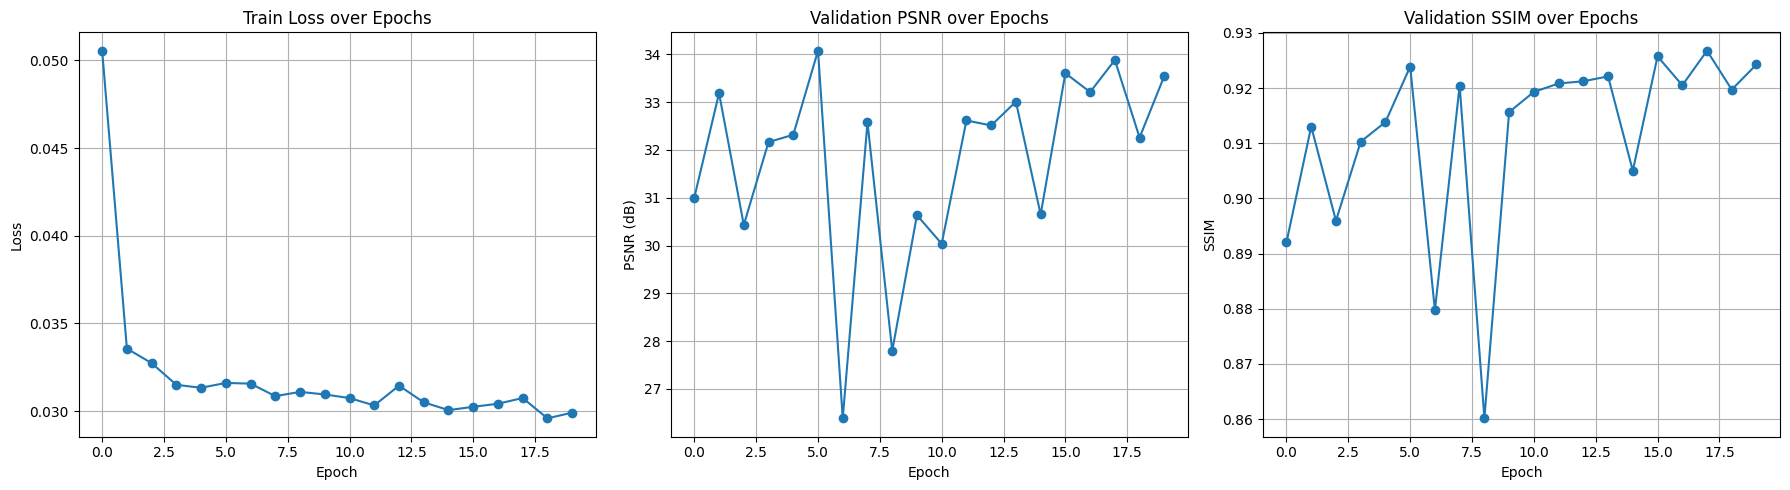

In [39]:
# ===========================================================
# Plot Train Loss, PSNR, SSIM over epochs
# ===========================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))

# ---- Train LOSS curve ----
plt.subplot(1, 3, 1)
plt.plot(train_losses, marker='o')
plt.title("Train Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# ---- PSNR curve ----
plt.subplot(1, 3, 2)
plt.plot(val_psnrs, marker='o')
plt.title("Validation PSNR over Epochs")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.grid(True)

# ---- SSIM curve ----
plt.subplot(1, 3, 3)
plt.plot(val_ssims, marker='o')
plt.title("Validation SSIM over Epochs")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.grid(True)

plt.tight_layout()
plt.show()


In [37]:
# ============================================================
# Convert 13-band image to RGB (bands 4-3-2)
# ============================================================
def to_rgb_from_13(img13):
    r = img13[:, :, 3]
    g = img13[:, :, 2]
    b = img13[:, :, 1]

    rgb = np.stack([r, g, b], axis=-1)

    # normalize for display
    rgb = rgb - rgb.min()
    if rgb.max() > 0:
        rgb = rgb / rgb.max()

    return np.clip(rgb, 0, 1)


# ============================================================
# Predict cloud-free output for a given aggregated image path
# ============================================================
def predict_cloud_free(agg_path):
    """
    agg_path: path to FMASK_COMPOSITE TIFF file
    Returns (rgb_input, rgb_output, full_13band_output)
    """

    # load TIFF
    X = load_tif(agg_path)        # (H, W, 13) scaled already
    H, W, C = X.shape

    # Apply val transform (CenterCrop + Normalize)
    augmented = val_transform(image=X, mask=X)  # mask unused
    X_t = augmented["image"].unsqueeze(0).to(device).float()  # (1,13,H,W)

    # Run model
    model.eval()
    with torch.no_grad():
        pred = model(X_t)[0].cpu().numpy().transpose(1, 2, 0)  # HWC

    # Convert both to RGB
    rgb_in  = to_rgb_from_13(X_t.cpu().numpy()[0].transpose(1,2,0))
    rgb_out = to_rgb_from_13(pred)

    return rgb_in, rgb_out, pred


# ============================================================
# Show prediction side-by-side
# ============================================================
def show_prediction_from_path(agg_path):
    rgb_in, rgb_out, pred_13 = predict_cloud_free(agg_path)

    plt.figure(figsize=(12, 6))

    # plt.subplot(1, 2, 1)
    # plt.imshow(rgb_in)
    # plt.title("Original Aggregated (RGB)")
    # plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(rgb_out)
    plt.title("Predicted Cloud-Free (RGB)")
    plt.axis("off")

    plt.show()

    return pred_13


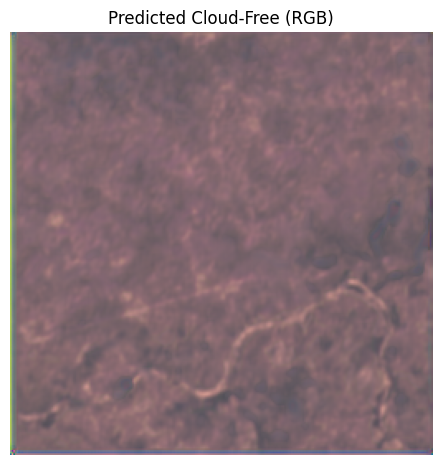

In [38]:
agg_path = r"D:\Timegate Images\ROIs1868_73\ROIs1868_73_S2_patch_0\2018-12-28_Fmask_composite_patch_0.tif"
predicted_13band = show_prediction_from_path(agg_path)
